In [1]:
_ = """
Desciption
- Visuelle products
- Not use of pytorch_forecasting
- year, month, day, dayofweek as positional embedding feature
"""

# Configurations

### Import

In [2]:
import os
import joblib
import random
from IPython.display import clear_output

import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tslearn.utils import to_time_series_dataset

import torch
from PIL import Image
from torchvision import transforms
from transformers import SwinModel

from transformers import ViTModel, ViTConfig, Mask2FormerModel, Mask2FormerConfig
import matplotlib.cm as cm
import cv2

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [3]:
# Sampling parameter
n_smaples = None

# Data parameter
random_state = 0
pred_len = 2
batch_size = 32
valid_start_idx = 8

# Model hyperparameter
d_model = 128; d_model = 256; d_model = 512
nhead = 4; nhead = 8
d_ff = 256; d_ff = 512; d_ff = 1024
dropout = 0.3
num_layers = 4; num_layers = 6

# Seed set
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)

# Data

### Read

In [4]:
# Read transaction
df_raw1 = pd.read_csv("../visuelle/train.csv", parse_dates=["release_date"])
df_raw2 = pd.read_csv("../visuelle/test.csv", parse_dates=["release_date"])
df_raw_ = pd.concat([df_raw1, df_raw2]).reset_index(drop=True)

# Melt date
df_raw = df_raw_.melt(
                id_vars=["image_path", "season", "category", "release_date", "color", "fabric", "extra"], 
                value_vars=[str(i) for i in range(12)], value_name="sales", 
                var_name="time_idx"
                )
df_raw["time_idx"] = df_raw["time_idx"].astype(int)
df_raw["sales"] = df_raw["sales"].apply(lambda x: x if x>0 else 0)
assert df_raw_.shape[0]*12 == df_raw.shape[0]

# Add date
def func(x):
    release_date = x["release_date"].iloc[0]
    date = pd.date_range(release_date, release_date+pd.DateOffset(months=12), freq="M")[:12]
    x["date"] = date
    return x
df_raw = df_raw.groupby(["image_path"], as_index=False).apply(lambda x: func(x)).reset_index(drop=True)

# Unscale
df_raw["sales"] = df_raw["sales"] * np.load("../visuelle/normalization_scale.npy")
df_raw["sales"] = df_raw["sales"].astype(int).apply(lambda x: x if x>0 else 1e-5)

df_train_raw = df_raw[df_raw["time_idx"] < valid_start_idx]
df_valid_raw = df_raw[df_raw["time_idx"] >= valid_start_idx]

### Preprocess

In [5]:
def preprocess(data):
    data = data.copy()

    # Make date positions
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month - 1
    
    # Aggregate with list
    data = data.groupby(["image_path", "season", "category", "release_date", "color", "fabric", "extra"], as_index=False)[["sales", "year", "month"]].agg(lambda x: list(x))
    data["size"] = data["sales"].str.len()

    # # Filter valid length
    # data = data[data["size"] >= pred_len]
    # print(f"Valid sized: {data.shape}")

    # Sampling
    if n_smaples:
        samples = data["image_path"].unique()
        data = data[data["image_path"].isin(samples[:n_smaples])]
        print(f"{min(n_smaples, data['image_path'].nunique())} sampled: {data.shape}")

    # Obtain imgpath
    data["img_path"] = data["image_path"].apply(lambda x: f'../visuelle/images/{x}') # Generate image path
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image
    print(f"Valid imaged:", data.shape)

    # Deal categorical values
    for col in ["season", "category", "extra", "size"]:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

    return data

In [6]:
df_train_prep = preprocess(df_train_raw); print("_"*100)
df_valid_prep = preprocess(df_valid_raw)

# Save
df_train_prep.to_parquet("df_train_prep.parquet")
df_valid_prep.to_parquet("df_valid_prep.parquet")

Valid imaged: (5577, 12)
____________________________________________________________________________________________________
Valid imaged: (5577, 12)


### Dataset

In [7]:
df_train_prep = pd.read_parquet("df_train_prep.parquet")
df_valid_prep = pd.read_parquet("df_valid_prep.parquet")

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.sales = data["sales"].values
        
        self.img = data["img_path"].values
        self.season = data["season"].values
        self.category = data["category"].values
        self.extra = data["extra"].values
        
        self.year = data["year"].values
        self.month = data["month"].values
    
    def __getitem__(self, idx):
        sales_raw = self.sales[idx]
        
        # # Scaling
        # sales_raw = np.log1p(sales_raw)

        # Process features
        sales = sales_raw[:-pred_len]
        valid_idx = np.where(sales>0)
        sales = np.log1p(sales[valid_idx])
        y = np.log1p(sales_raw[-pred_len:])

        img = Image.open(self.img[idx]).convert("RGB")
        img_tensor = self.transform(img).numpy()
        season = self.season[idx]
        category = self.category[idx]
        extra = self.extra[idx]

        year = self.year[idx][:-pred_len]
        year = year[valid_idx]
        month = self.month[idx][:-pred_len]
        month = month[valid_idx]

        assert sales.shape == year.shape == month.shape

        return sales, img, img_tensor, season, category, extra, year, month, y

    def __len__(self):
        return self.img.shape[0]

train_dataset = Dataset(df_train_prep)
valid_dataset = Dataset(df_valid_prep)

def func(data):
    sales = np.nan_to_num(to_time_series_dataset([sales_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data]), nan=0).squeeze()

    img = ([img_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data])
    img_tensor = np.array([img_tensor_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data])
    season = np.array([season_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data])
    category = np.array([category_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data])
    extra = np.array([extra_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data])

    year = np.nan_to_num(to_time_series_dataset([year_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data]), nan=0).squeeze()
    month = np.nan_to_num(to_time_series_dataset([month_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data]), nan=0).squeeze()
    
    y = np.array([y_ for sales_, img_, img_tensor_, season_, category_, extra_, year_, month_, y_ in data])

    sales = torch.FloatTensor(sales).unsqueeze(-1)
    img_tensor = torch.FloatTensor(img_tensor)
    season = torch.IntTensor(season)
    category = torch.IntTensor(category)
    extra = torch.IntTensor(extra)

    year = torch.FloatTensor(year).unsqueeze(-1)
    month = torch.IntTensor(month)

    y = torch.FloatTensor(y)

    return sales, img, img_tensor, season, category, extra, year, month, y

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=8, shuffle=True, collate_fn=func)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=func)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=8, collate_fn=func)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, collate_fn=func)

for sales, img, img_tensor, season, category, extra, year, month, y in train_dataloader:
    print("sales.shape:", sales.shape)
    print("img_tensor.shape:", img_tensor.shape)
    print("season.shape:", season.shape)
    print("category.shape:", category.shape)
    print("extra.shape:", extra.shape)
    print("year.shape:", year.shape)
    print("month.shape:", month.shape)
    print("y.shape:", y.shape)
    break

sales.shape: torch.Size([32, 6, 1])
img_tensor.shape: torch.Size([32, 3, 224, 224])
season.shape: torch.Size([32])
category.shape: torch.Size([32])
extra.shape: torch.Size([32])
year.shape: torch.Size([32, 6, 1])
month.shape: torch.Size([32, 6])
y.shape: torch.Size([32, 2])


# Modeling

### Architecture

### Original

In [9]:
# Original
verbose = False
class Mask(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor).to(device)
        res = torch.where(res==1, -torch.inf, 0)
        return res
    
    def get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-torch.inf, 1).to(device)
        return mask

    def forward(self, arr):
        padding_mask = self.get_padding_mask(arr)
        lookahead_mask = self.get_lookahead_mask(arr)
        return padding_mask, lookahead_mask

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.year_embedder = torch.nn.Linear(1, d_model)
        self.year_activation = torch.nn.ELU()

        self.month_embedder = torch.nn.Embedding(num_embeddings=12, embedding_dim=d_model)

        self.linear_embedder = torch.nn.Linear(d_model*2, d_model)
        self.linear_activation = torch.nn.ELU()

        self.linear = torch.nn.Linear(d_model, d_model)

    def forward(self, year, month):
        year_embedding = self.year_activation(self.year_embedder(year))
        month_embedding = self.month_embedder(month)

        concat = torch.concat([year_embedding, month_embedding], dim=-1)
        embedding = self.linear_activation(self.linear_embedder(concat))
        embedding = self.linear(embedding)

        if verbose: print("year_embedding", torch.isnan(year_embedding).sum())        
        if verbose: print("month_embedding", torch.isnan(month_embedding).sum())
        if verbose: print("embedding", torch.isnan(embedding).sum())
        if verbose: print("embedding", torch.isnan(embedding).sum())
        return embedding

class Encoder(torch.nn.Module):
    def __init__(self, dropout, d_model, nhead, d_ff, num_layers):
        super().__init__()
        # Positional encoding
        self.sales_dropout = torch.nn.Dropout(dropout)
        self.sales_embedder = torch.nn.Linear(1, d_model)
        self.sales_activation = torch.nn.ELU()

        # Encoding
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, sales, positional_embedding, enc_padding_mask):
        # Positional encoding
        sales_embedding = self.sales_activation(self.sales_embedder(sales))
        if verbose: print("sales_embedding", torch.isnan(sales_embedding).sum())
        sales_positional_embedding = self.sales_dropout(sales_embedding + positional_embedding)
        if verbose: print("sales_positional_embedding", torch.isnan(sales_positional_embedding).sum())

        # Encoding
        encoding = self.encoder(sales_positional_embedding, src_key_padding_mask=enc_padding_mask)
        # encoding = self.encoder(sales_positional_embedding)
        if verbose: print("encoding", torch.isnan(encoding).sum())
        encoding
        
        return encoding

class Decoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, num_layers):
        super().__init__()
        # Image model train
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        # self.img_model = ViTModel(ViTConfig())
        self.img_activation = torch.nn.ELU()
        
        # Image model embedding
        self.img_embedder = torch.nn.Linear(self.img_model.config.hidden_size, d_model)
        self.img_embedding_activation = torch.nn.ELU()

        # Others embedding
        self.season_embedder = torch.nn.Embedding(num_embeddings=6, embedding_dim=d_model)
        self.category_embedder = torch.nn.Embedding(num_embeddings=27, embedding_dim=d_model)
        self.extra_embedder = torch.nn.Embedding(num_embeddings=23, embedding_dim=d_model)
        self.others_linear = torch.nn.Linear(d_model*4, d_model)
        self.others_activation = torch.nn.ELU()

        # Decoding
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, img_tensor, season, category, extra, encoder_output, enc_padding_mask):
        img_hidden_state, pooler_output, attn_weight = self.img_model(img_tensor, output_attentions=True).values()
        img_hidden_state = self.img_activation(img_hidden_state)

        img_embedding = self.img_embedding_activation(self.img_embedder(img_hidden_state))
        
        season_embedding = self.season_embedder(season).unsqueeze(1).repeat(1, 197,1)
        category_embedding = self.category_embedder(category).unsqueeze(1).repeat(1, 197,1)
        extra_embedding = self.extra_embedder(extra).unsqueeze(1).repeat(1, 197,1)
        concat = torch.concat([img_embedding, season_embedding, category_embedding, extra_embedding], dim=-1)
        total_embedding = self.others_activation(self.others_linear(concat))

        dec_output = self.decoder(tgt=total_embedding, memory=encoder_output, memory_key_padding_mask=enc_padding_mask)

        if verbose: print("img_hidden_state", torch.isnan(img_hidden_state).sum())
        if verbose: print("img_embedding", torch.isnan(img_embedding).sum())
        if verbose: print("img_hidden_state", torch.isnan(img_hidden_state).sum())
        if verbose: print("dec_output", torch.isnan(dec_output).sum())
        
        return dec_output, attn_weight

class Transformer(torch.nn.Module):
    def __init__(self, d_model, dropout, nhead, d_ff, num_layers, pred_len):
        super().__init__()
        self.enc_mask = Mask()
        self.positional_embedder = PositionalEmbedding(d_model)
        
        self.encoder = Encoder(dropout, d_model, nhead, d_ff, num_layers)
        self.decoder = Decoder(d_model, nhead, d_ff, dropout, num_layers)

        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(d_model*197, d_model)
        self.elu1 = torch.nn.ELU()
        
        self.linear2 = torch.nn.Linear(d_model, pred_len)
    
    def forward(self, sales, img_tensor, season, category, extra, year, month):
        enc_padding_mask, _ = self.enc_mask(sales.squeeze(-1))
        if verbose: print("enc_padding_mask", torch.isnan(enc_padding_mask).sum()); print("enc_padding_mask.shape", enc_padding_mask.shape)
        positional_embedding = self.positional_embedder(year, month)
        if verbose: print("positional_embedding", torch.isnan(positional_embedding).sum()); print("positional_embedding.shape", positional_embedding.shape)

        encoder_output = self.encoder(sales, positional_embedding, enc_padding_mask)
        decoder_output, attn_weight = self.decoder(img_tensor, season, category, extra, encoder_output, enc_padding_mask)
        
        output = self.elu1(self.linear1(self.flatten(decoder_output)))
        output = self.linear2(output)
        
        return output, attn_weight

model = Transformer(d_model, dropout, nhead, d_ff, num_layers, pred_len).to(device)

### New

In [10]:
verbose = False

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.year_embedder = torch.nn.Linear(1, d_model)
        self.year_activation = torch.nn.ELU()

        self.month_embedder = torch.nn.Embedding(num_embeddings=12, embedding_dim=d_model)

        self.batch_norm = torch.nn.LayerNorm(normalized_shape=d_model*2)
        self.linear_embedder = torch.nn.Linear(d_model*2, d_model)
        self.linear_activation = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(dropout)

        self.linear = torch.nn.Linear(d_model, d_model)


    def forward(self, year, month):
        year_embedding = self.year_activation(self.year_embedder(year))
        month_embedding = self.month_embedder(month)

        concat = torch.concat([year_embedding, month_embedding], dim=-1)
        concat = self.batch_norm(concat)
        embedding = self.linear_activation(self.linear_embedder(concat))
        embedding = self.dropout(embedding)
        embedding = self.linear(embedding)

        if verbose: print("year_embedding", torch.isnan(year_embedding).sum())        
        if verbose: print("month_embedding", torch.isnan(month_embedding).sum())
        if verbose: print("embedding", torch.isnan(embedding).sum())
        if verbose: print("embedding", torch.isnan(embedding).sum())
        return embedding

class Encoder(torch.nn.Module):
    def __init__(self, dropout, d_model, nhead, d_ff, num_layers):
        super().__init__()
        # Positional encoding
        self.sales_dropout = torch.nn.Dropout(dropout)
        self.sales_embedder = torch.nn.Linear(1, d_model)
        self.sales_activation = torch.nn.ELU()

        # Encoding
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, sales, positional_embedding, enc_padding_mask):
        # Positional encoding
        sales_embedding = self.sales_activation(self.sales_embedder(sales))
        sales_positional_embedding = self.sales_dropout(sales_embedding + positional_embedding)

        # Encoding
        encoding = self.encoder(sales_positional_embedding, src_key_padding_mask=enc_padding_mask)

        if verbose: print("sales_embedding", torch.isnan(sales_embedding).sum())        
        if verbose: print("sales_positional_embedding", torch.isnan(sales_positional_embedding).sum())
        if verbose: print("encoding", torch.isnan(encoding).sum())
        
        return encoding

class Decoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, num_layers):
        super().__init__()
        self.d_model = d_model

        # Image model train
        # self.img_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        # self.img_model = ViTModel(ViTConfig())
        # self.img_model = Mask2FormerModel.from_pretrained("facebook/mask2former-swin-small-coco-instance")
        # self.img_model = Mask2FormerModel(Mask2FormerConfig())

        self.img_activation = torch.nn.ELU()
        
        # Image model embedding
        self.img_embedder = torch.nn.Linear(self.img_model.config.hidden_size, d_model)
        self.img_embedding_activation = torch.nn.ELU()
        self.img_linear = torch.nn.Linear(d_model, d_model)

        # Decoding
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
        self.flatten = torch.nn.Flatten()
        self.output_linear = torch.nn.Linear(49*d_model, d_model)
        self.output_actication = torch.nn.ELU()

        # Others embedding
        # self.season_embedder = torch.nn.Embedding(num_embeddings=6, embedding_dim=d_model*49)
        # self.category_embedder = torch.nn.Embedding(num_embeddings=27, embedding_dim=d_model*49)
        # self.extra_embedder = torch.nn.Embedding(num_embeddings=23, embedding_dim=d_model*49)
        self.season_embedder = torch.nn.Embedding(num_embeddings=6, embedding_dim=d_model*197)
        self.category_embedder = torch.nn.Embedding(num_embeddings=27, embedding_dim=d_model*197)
        self.extra_embedder = torch.nn.Embedding(num_embeddings=23, embedding_dim=d_model*197)
        
        self.total_layer_norm = torch.nn.LayerNorm(d_model*4)
        self.total_linear = torch.nn.Linear(d_model*4, d_model)
        self.total_activation = torch.nn.ELU()
    
    def forward(self, img_tensor, img_mask, season, category, extra, encoder_output, enc_padding_mask):
        num = 197
        img_hidden_state, pooler_output, attn_weight = self.img_model(img_tensor, output_attentions=True).values() # For ViT
        # encoder_last_hidden_state, pixel_decoder_last_hidden_state, transformer_decoder_last_hidden_state, masks_queries_logits, attn_weight = self.img_model(pixel_values=img_tensor, pixel_mask=img_mask, output_attentions=True).values() # For Mask2Former
        # img_hidden_state = transformer_decoder_last_hidden_state
        # img_hidden_state = self.img_activation(img_hidden_state)
        img_embedding = self.img_linear(self.img_embedding_activation(self.img_embedder(img_hidden_state)))
        season_embedding = self.season_embedder(season).reshape(-1, num, self.d_model)
        category_embedding = self.category_embedder(category).reshape(-1, num, self.d_model)
        extra_embedding = self.extra_embedder(extra).reshape(-1, num, self.d_model)
        concat = self.total_activation(self.total_linear(self.total_layer_norm(torch.concat([img_embedding, season_embedding, category_embedding, extra_embedding], dim=-1))))

        # dec_output = self.decoder(tgt=img_embedding, memory=encoder_output, memory_key_padding_mask=enc_padding_mask)      
        dec_output = self.decoder(tgt=concat, memory=encoder_output, memory_key_padding_mask=enc_padding_mask)      
        return dec_output, attn_weight

class Transformer(torch.nn.Module):
    def __init__(self, d_model, dropout, nhead, d_ff, num_layers, pred_len):
        super().__init__()
        # self.enc_mask = Mask()
        self.positional_embedder = PositionalEmbedding(d_model, dropout)
        
        self.encoder = Encoder(dropout, d_model, nhead, d_ff, num_layers)
        self.decoder = Decoder(d_model, nhead, d_ff, dropout, num_layers)

        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(d_model, d_model)
        # self.linear1 = torch.nn.Linear(d_model*100, d_model)
        # self.linear1 = torch.nn.Linear(d_model, d_model)
        self.elu1 = torch.nn.ELU()
        
        self.linear2 = torch.nn.Linear(d_model, 1)
    
    def _get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor).to(device)
        res = torch.where(res==1, -torch.inf, 0)
        return res
    
    def _get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-torch.inf, 1)
        return mask

    def get_mask(self, arr):
        padding_mask = self._get_padding_mask(arr)
        lookahead_mask = self._get_lookahead_mask(arr)
        return padding_mask, lookahead_mask

    def forward(self, sales, img_tensor, img_mask, season, category, extra, year, month):
        enc_padding_mask, _ = self.get_mask(sales.squeeze(-1))
        positional_embedding = self.positional_embedder(year, month)

        encoder_output = self.encoder(sales, positional_embedding, enc_padding_mask)
        decoder_output, attn_weight = self.decoder(img_tensor, img_mask, season, category, extra, encoder_output, enc_padding_mask)
        # print(decoder_output.shape)
        output = self.elu1(self.linear1(decoder_output))
        output = self.linear2(output)[:, :pred_len, :].squeeze()
        
        return output, attn_weight

model = Transformer(d_model, dropout, nhead, d_ff, num_layers, pred_len)
# model = torch.nn.DataParallel(model)
model.to(device)
""

''

### Train

### Original

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

def plot_sample(y, pred):
    # Plot sample
    clear_output(wait=True)
    y_sample = y[-1]
    pred_sample = pred[-1].detach().cpu()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.title("Sample")
    plt.legend()
    plt.show()

def train(epoch, val_loss, train_loss_li, val_loss_li):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        sales, img, img_tensor, season, category, extra, year, month, y = data

        # Train
        optimizer.zero_grad()
        pred, attn_weight = model(sales.to(device), img_tensor.to(device), season.to(device), category.to(device), extra.to(device), year.to(device), month.to(device))
        pred = pred.squeeze()

        # plot sample
        if not verbose: 
            if n % 10 == 0: plot_sample(np.expm1(y), np.expm1(pred.detach().cpu()))
        loss = loss_fn(pred, y.to(device))
        if verbose:
            print("sales:", sales)
            print("y:", y)
            print(pred)
            print(y)
            print(loss)
            print("_"*100)
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        if not verbose: print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_loss}", end="")

    print()
    return mean_loss

def val(epoch):
    model.eval()
    total_len = len(valid_dataloader)
    total_loss = 0
    for n, data in enumerate(valid_dataloader):
        sales, img, img_tensor, season, category, extra, year, month, y = data
        
        # Pred
        with torch.no_grad():
            pred, attn_weight = model(sales.to(device), img_tensor.to(device), season.to(device), category.to(device), extra.to(device), year.to(device), month.to(device))
            pred = pred.squeeze()
            loss = loss_fn(pred, y.to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            print(f"\r {epoch}:{n}/{total_len} mean_val_loss: {mean_loss}", end="")

    print()
    return mean_loss
 
epoch = 5
train_loss_li, val_loss_li = [0], [0]
val_loss = 0

for e in range(epoch):
    train_loss = train(e, val_loss, train_loss_li, val_loss_li) # Train
    val_loss = val(e)

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    torch.save(model.state_dict(), f"model_{np.mean(train_loss)}_{np.mean(val_loss)}.pth")

TypeError: forward() missing 1 required positional argument: 'month'

### New

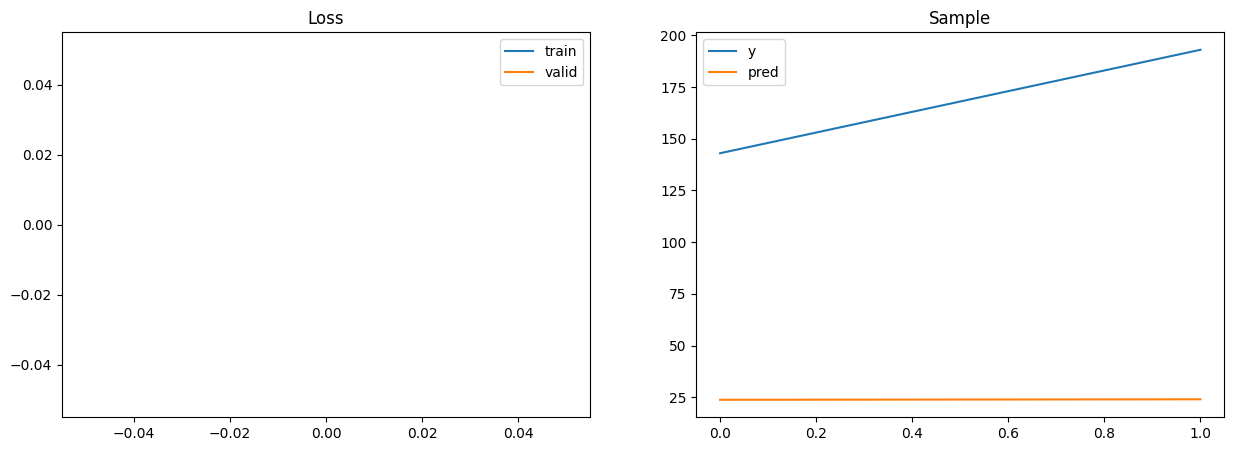

 0:174/175 mean_train_loss: 1.7132895185266221 -- mean_val_loss: 0


/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


 0:168/175 mean_val_loss: 5.3141060192909465

KeyboardInterrupt: 

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def get_image_mask(img):
    # Get image mask
    img_mask = []

    for i in img:
        i = transform(i)
        mask = torch.ne(i, 0).type(torch.FloatTensor)
        mask = torch.sum(mask, dim=0)
        img_mask.append(mask)
    return torch.stack(img_mask).to(device)

def plot_sample(y, pred):
    # Plot sample
    clear_output(wait=True)
    y_sample = y[-1]
    pred_sample = pred[-1].detach().cpu()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.title("Sample")
    plt.legend()
    plt.show()

temp_img = None
temp_mask = None
def train(epoch, val_loss, train_loss_li, val_loss_li):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        sales, img, img_tensor, season, category, extra, year, month, y = data
        img_mask = get_image_mask(img)
        global temp_mask, temp_img
        temp_mask = img_mask
        temp_img = img
        
        # Train
        optimizer.zero_grad()
        pred, attn_weight = model(sales.to(device), img_tensor.to(device), img_mask.to(device), season.to(device), category.to(device), extra.to(device), year.to(device), month.to(device))
        pred = pred.squeeze()

        # plot sample
        if not verbose: 
            if n % 10 == 0: plot_sample(np.expm1(y), np.expm1(pred.detach().cpu()))
        loss = loss_fn(pred, y.to(device))
        # loss = loss_fn(pred, y.cuda())
        if verbose:
            print("sales:", sales); print("y:", y); print(pred); print(y); print(loss); print("_"*100); 
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        if not verbose: print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_loss}", end="")

    print()
    return mean_loss

def val(epoch):
    model.eval()
    total_len = len(valid_dataloader)
    total_loss = 0
    for n, data in enumerate(valid_dataloader):
        sales, img, img_tensor, season, category, extra, year, month, y = data
        img_mask = get_image_mask(img)
        
        # Pred
        with torch.no_grad():
            pred, attn_weight = model(sales.to(device), img_tensor.to(device), img_mask.to(device), season.to(device), category.to(device), extra.to(device), year.to(device), month.to(device))
            pred = pred.squeeze()
            loss = loss_fn(pred, y.to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            print(f"\r {epoch}:{n}/{total_len} mean_val_loss: {mean_loss}", end="")

    print()
    return mean_loss
 
epoch = 5
train_loss_li, val_loss_li = [0], [0]
val_loss = 0

for e in range(epoch):
    train_loss = train(e, val_loss, train_loss_li, val_loss_li) # Train
    val_loss = val(e)

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    torch.save(model.state_dict(), f"model_{np.mean(train_loss)}_{np.mean(val_loss)}.pth")

In [ ]:
# torch.save(model.state_dict(), f"model_ref.pth")

### Eval

In [16]:
def get_attention_map(img, att_mat, get_mask=False):
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    print("att_mat.shape:", att_mat.shape)
    # att_mat = torch.max(att_mat, dim=1).values

    # To account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    print("joint_attentions.shape:", joint_attentions.shape)
    v = joint_attentions[-1]
    print("v.shape:", v.shape)
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    print("grid_size.shape:", grid_size)
    print(v[0, 1:].shape)
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    # mask = v[0].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

# def get_attention_map(img, att_mat, get_mask=False):
    # Average the attention weights across all heads.
    att_mat = [torch.mean(i, dim=1) for i in att_mat]
    att_mat = torch.concat(att_mat, dim=0)
    
    # att_mat = torch.max(att_mat, dim=1).values

    # To account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    print("joint_attentions.shape:", joint_attentions.shape)
    v = joint_attentions[-1]
    print("v.shape:", v.shape)
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    print("grid_size.shape:", grid_size)
    print(v[0, 1:].shape)
    # mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = v[0].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map, loss):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 5))
    ax1.set_title('Original')
    ax2.set_title(loss)
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map, cmap = cm.gray)

att_mat.shape: torch.Size([12, 197, 197])
joint_attentions.shape: torch.Size([12, 197, 197])
v.shape: torch.Size([197, 197])
grid_size.shape: 14
torch.Size([196])


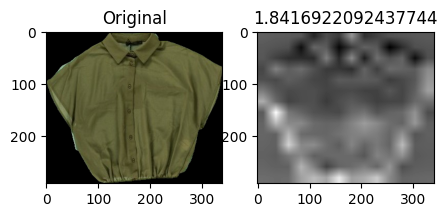

KeyboardInterrupt: Interrupted by user

In [17]:
from transformers import AutoImageProcessor, SwinModel, SwinForImageClassification, ViTModel, ViTForImageClassification
import matplotlib.cm as cm
from gradcam import GradCAM
from gradcam.utils import visualize_cam
import cv2
import time

model.eval()
data = next(iter(valid_dataloader))

for data in valid_dataloader:
    sales, img, img_tensor, season, category, extra, year, month, y = data

    for idx in range(len(data)):
        sales_ = sales[idx:idx+1]
        img_ = img[idx]
        img_mask_ = get_image_mask([img_])
        img_tensor_ = img_tensor[idx:idx+1]
        season_ = season[idx:idx+1]
        category_ = category[idx:idx+1]
        extra_ = extra[idx:idx+1]
        year_ = year[idx:idx+1]
        month_ = month[idx:idx+1]
        y_ = y[idx:idx+1]

        with torch.no_grad():
            pred, attn_weight = model(sales_.to(device), img_tensor_.to(device), img_mask_.to(device), season_.to(device), category_.to(device), extra_.to(device), year_.to(device), month_.to(device))
            # pred, attn_weight = model(sales_.to(device), img_tensor_.to(device), season_.to(device), category_.to(device), extra_.to(device), year_.to(device), month_.to(device))
            loss = loss_fn(pred, y.to(device)).item()
        res = get_attention_map(img_, tuple(i.detach().cpu() for i in attn_weight), get_mask=True)
        plot_attention_map(img_, res, loss)
        # get_myattention(attn_weight, img_)
        plt.show()
        input()
        clear_output(wait=True)
        time.sleep(0.5)

In [ ]:
day_.squeeze(-1).shape

torch.Size([1, 77])